# Core Workflow: Applying Model
Load existing, trained model from file and apply it to imagery (and other inputs) in order to generate a comprehensive LULC raster covering the entire urban extent of a given city. Allows user to preview LULC tiles and compare against VIR component of input stack.  
  
Date: 2018-09-17  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'hyderabad'

data_root='/data/phase_iii/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

tile_resolution = resolution
tile_size = 256
tile_pad = 16

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

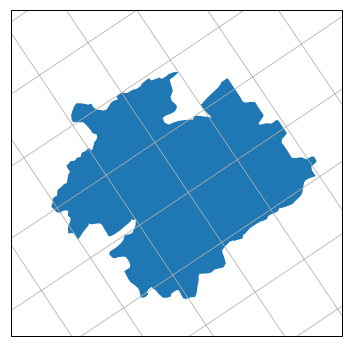

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 458
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.1775006012039, 17.529165535205387], [78.20460181878519, 17.52954978485592], [78.20420289377427, 17.555551127046854], [78.17709782110293, 17.55516627151902], [78.1775006012039, 17.529165535205387]]]}


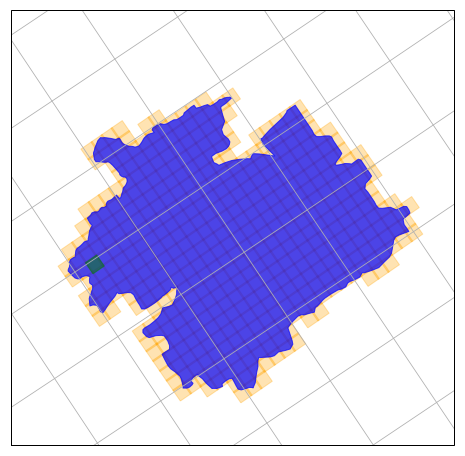

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Set input stack and model parameters

In [5]:
window = 7    # width of square window

bands_vir=bands[:-1]
bands_sar=s1_bands
bands_ndvi=None
bands_ndbi=None
bands_osm=None

haze_removal = False

image_suffix = 'A'

model_id = 'phase_iii_demo_3'

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+sar 8


### Load model objects

In [7]:
scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'_DLv3.hd5'

with open(scaler_filename, "rb") as f:
    scaler = pickle.load(f)
f.close()

with open(model_filename, "rb") as f:
    model = pickle.load(f)
f.close()

network = load_model(network_filename)

### Apply model to classify LULC

In [19]:
util_workflow.classify_tiles(data_path, place, tiles, image_suffix,
        window, stack_label, feature_count, model_id, scaler, network,
        bands_vir=bands_vir,
        bands_sar=bands_sar, bands_ndvi=None, bands_ndbi=None, bands_osm=None,
        haze_removal=False)

Feature count: 8
Stack label:  vir+sar
tile 0 load VIR image
vir shape: (7, 288, 288)
5569 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2155 )
vir band 1 into imn band 1 ( 0.0 - 0.2232 )
vir band 2 into imn band 2 ( 0.0 - 0.2465 )
vir band 3 into imn band 3 ( 0.0 - 0.3755 )
vir band 4 into imn band 4 ( 0.0 - 0.3242 )
vir band 5 into imn band 5 ( 0.0 - 0.25 )
tile 0 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 65452
1 70
2 2
3 12
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile000_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 0 done
tile 1 load VIR image
vir shape: (7, 288, 288)
34215 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2658 )
vir band 1 into imn band 1 ( 0.0 - 0.2813 )
vir band 2 into imn b

KeyboardInterrupt: 

### View generated LULC tile (and source image)

/data/phase_iii/hyderabad/maps/hyderabad_tile368_phase_iii_demo_3_lulc_A.tif
0 37131 Open Space
1 16161 Non-Residential
2 9751 Residential Atomistic
3 2493 Residential Informal Subdivision
254 17408 No Data
0 61 255
1 78 255
2 94 253


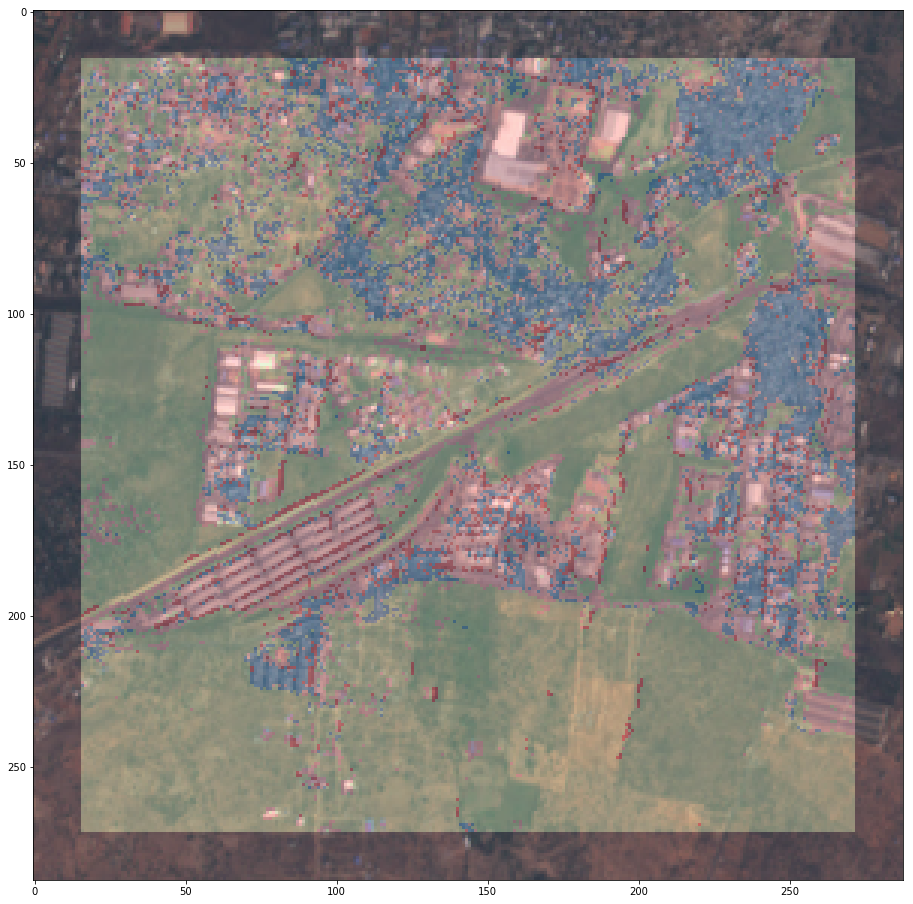

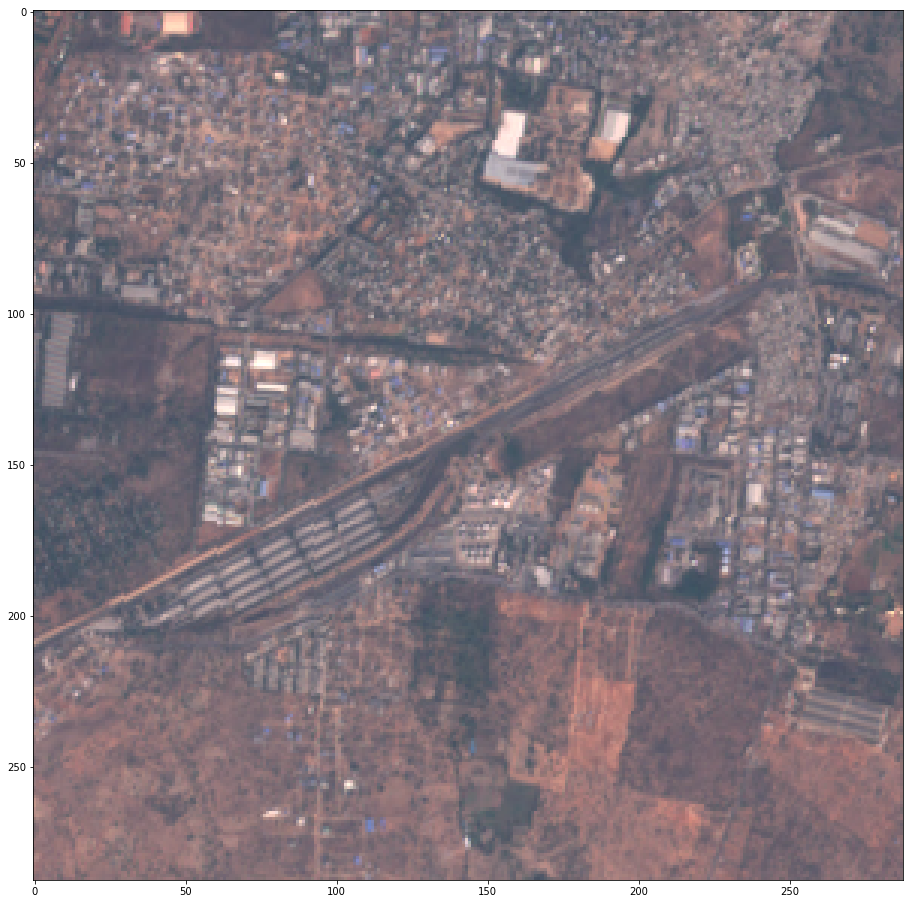

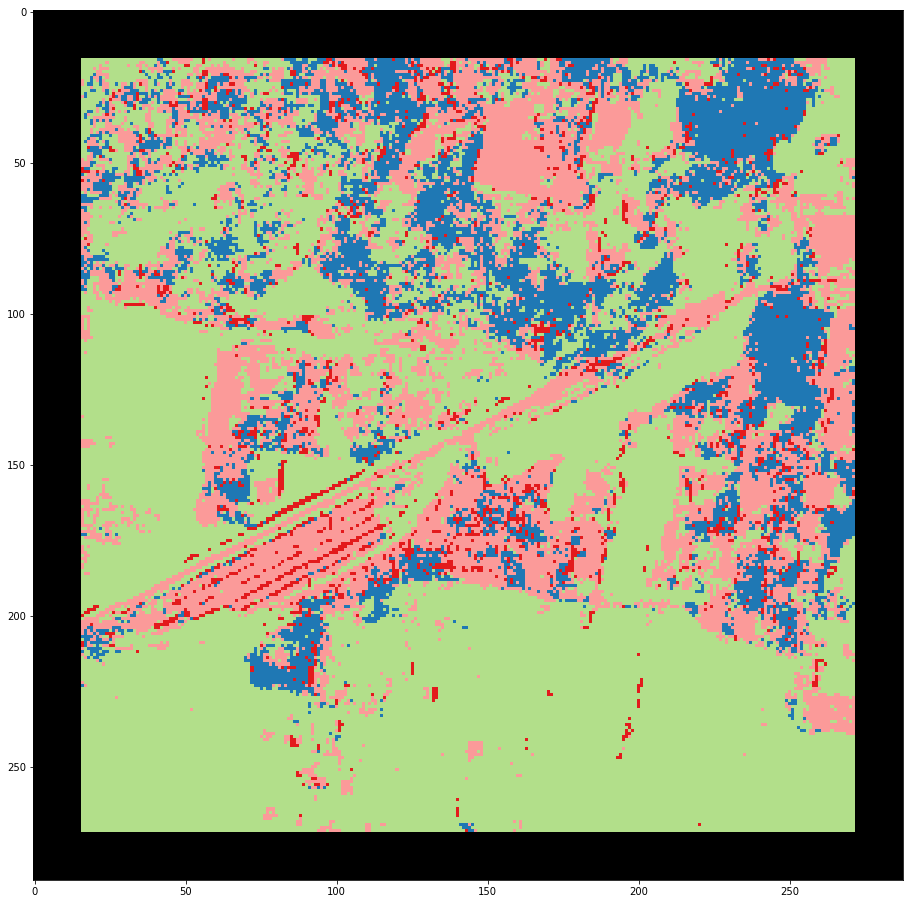

In [17]:
util_workflow.view_results_overlay(data_path, place, 368, model_id, image_suffix, show_vir=True, show_lulc=True)